<h1 align = "center">Hyperparameter Search</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import latte
import latte.nn as nn
import latte.optim as optim
import latte.functional as F
import latte.utils.data as data

import lattevision as lv
import lattevision.datasets as dsets
import lattevision.transforms as T


In [2]:
mnist_root = '../data/mnist'
mnist_transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

mnist_train = dsets.MNIST(mnist_root, train=True, transform=mnist_transform)
mnist_test = dsets.MNIST(mnist_root, train=False, transform=mnist_transform)

val_len = len(mnist_train) // 10
train_len = len(mnist_train) - val_len
mnist_train, mnist_val = data.random_split(mnist_train, [train_len, val_len])

train_batch_size = 128
test_batch_size = 512

train_loader = data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
val_loader = data.DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
test_loader = data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)


## 1. Define Tuner

Configuration:

    - model: MLP
    - optimizer: SGD
    - momentum: 0
    - loss: MSELoss
    - batch_size: 128
    - max_epochs: 50
    - initial lr: 1e-2
    - lr decay: 0.9
    - dropout: False
    - fine tuning: True

In [3]:
def create_model(hidden_units):

    class Model(nn.Module):
        def __init__(self) -> None:
            super().__init__()
            self.fc1 = nn.Linear(784, hidden_units)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_units, 10)

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            return out

    model = Model()
    return model


In [4]:
class Tuner:
    def __init__(self, model, weight_decay, train_loader, val_loader, test_loader):
        self.model = model
        self.optimizer = optim.SGD(
            self.model.parameters(), lr=1e-2, momentum=0, weight_decay=weight_decay
        )
        self.criterion = nn.MSELoss()  # Work with fine tuning to accelerate training
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        # Best model & training info
        self.best_model_param = None
        self.lrs = []
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train(self, max_epochs=50, lr_decay=0.9):
        best_epoch = 0

        for epoch in range(max_epochs):
            train_loss = 0
            train_batchs = 0
            for ii, (data, target) in enumerate(self.train_loader):
                batch_size = data.shape[0]
                if batch_size != data.shape[0]:
                    continue
                train_batchs += 1

                data = latte.Tensor(data.reshape(batch_size, -1))
                target_mse = np.zeros((batch_size, 10))
                target_mse[np.arange(batch_size), target] = 1
                target_mse = latte.Tensor(target_mse)

                # Forward pass
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target_mse)
                train_loss += loss.data

                # Backward pass
                loss.backward()
                self.optimizer.step()

            train_loss /= train_batchs

            # Fine tuning
            self._fine_tuning()

            # Validation
            val_loss, val_accuracy = self._validate()

            # Learning rate decay & update best model
            if epoch > 0:
                if val_loss < self.val_losses[-1]:
                    best_epoch = epoch
                    self.best_model_param = self.model.parameters()
                else:
                    self.optimizer.lr_decay(lr_decay)

            # Logging
            self.lrs.append(self.optimizer.lr)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            # Print
            if (epoch + 1) % 10 == 0:
                print("==========================================================")
                print(f"Epoch: {epoch + 1}/{max_epochs}")
                print(f"\tLearning Rate: {self.optimizer.lr: .4f}\tTrain Loss: {train_loss: .4f}")
                print(f"\tVal Loss: {val_loss: .4f}\tVal Accuracy: {val_accuracy: .4f}")

        # Print best model info
        print("==========================================================")
        print(f"Training Finished. Best Epoch: {best_epoch + 1}/{max_epochs}")
        print(f"\tBest Val Loss: {self.val_losses[best_epoch]: .4f}")
        print(f"\tBest Val Accuracy: {self.val_accuracies[best_epoch]: .4f}")

    def _validate(self):
        val_loss = 0
        val_accuracy = 0
        val_batchs = 0

        for data, target in self.val_loader:
            batch_size = data.shape[0]
            if batch_size != data.shape[0]:
                continue
            val_batchs += 1

            data = latte.Tensor(data.reshape(batch_size, -1))
            target_mse = np.zeros((batch_size, 10))
            target_mse[np.arange(batch_size), target] = 1
            target_mse = latte.Tensor(target_mse)

            # Forward pass
            output = self.model(data)
            loss = self.criterion(output, target_mse)
            val_loss += loss.data

            # Accuracy
            accuracy = (output.data.argmax(axis=1) == target).mean()
            val_accuracy += accuracy

        val_loss /= val_batchs
        val_accuracy /= val_batchs

        return val_loss, val_accuracy

    def _fine_tuning(self):
        x_ft, y_ft = [], []
        for data, target in train_loader:
            batch_size = data.shape[0]
            if batch_size != train_batch_size:
                continue

            data = latte.Tensor(data.reshape(batch_size, -1))
            target_mse = np.zeros((batch_size, 10))
            target_mse[np.arange(batch_size), target] = 1
            target_mse = latte.Tensor(target_mse)

            data = self.model.fc1(data)
            data = self.model.relu(data)

            x_ft.append(data.data)
            y_ft.append(target_mse.data)

        fc2_bias_data = self.model.fc2.bias.data
        x_ft = np.concatenate(x_ft)
        y_ft = np.concatenate(y_ft)
        x_ft_mpinv = np.matmul(
            np.linalg.pinv(np.matmul(x_ft.T, x_ft)), x_ft.T
        )  # Moore-Penrose pseudoinverse
        fc2_weight_data = np.matmul(
            x_ft_mpinv, (y_ft - fc2_bias_data)
        )  # (X^T * X)^-1 * X^T * (Y - b)
        self.model.fc2.weight.data = fc2_weight_data

    def save_best(self, filename):
        latte.save(self.best_model_param, filename)

    def test(self, filename):
        self.model.load(filename)
        correct = 0
        total = 0

        for data, target in self.test_loader:
            batch_size = data.shape[0]
            if batch_size != test_batch_size:
                continue

            data = latte.Tensor(data.reshape(batch_size, -1))

            output = self.model(data)
            correct += (output.data.argmax(axis=1) == target).sum()
            total += target.shape[0]

        print("==========================================================")
        print(f"Test Accuracy: {(correct / total): .4f}")


## 2. Search

Search Space:

    - hidden units: [64, 128, 256, 512]
    - weight decay: [0, 1e-5]


### 2.1. Hidden Units 64 & Weight Decay 0

In [5]:
model = create_model(hidden_units=64)
tuner = Tuner(model, 0, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model_64.npy"
tuner.train(max_epochs=50)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/50
	Learning Rate:  0.0100	Train Loss:  0.0066
	Val Loss:  0.0070	Val Accuracy:  0.9464
Epoch: 20/50
	Learning Rate:  0.0100	Train Loss:  0.0056
	Val Loss:  0.0062	Val Accuracy:  0.9512
Epoch: 30/50
	Learning Rate:  0.0100	Train Loss:  0.0051
	Val Loss:  0.0059	Val Accuracy:  0.9547
Epoch: 40/50
	Learning Rate:  0.0100	Train Loss:  0.0048
	Val Loss:  0.0057	Val Accuracy:  0.9548
Epoch: 50/50
	Learning Rate:  0.0081	Train Loss:  0.0045
	Val Loss:  0.0055	Val Accuracy:  0.9556
Training Finished. Best Epoch: 50/50
	Best Val Loss:  0.0055
	Best Val Accuracy:  0.9556
Test Accuracy:  0.9650


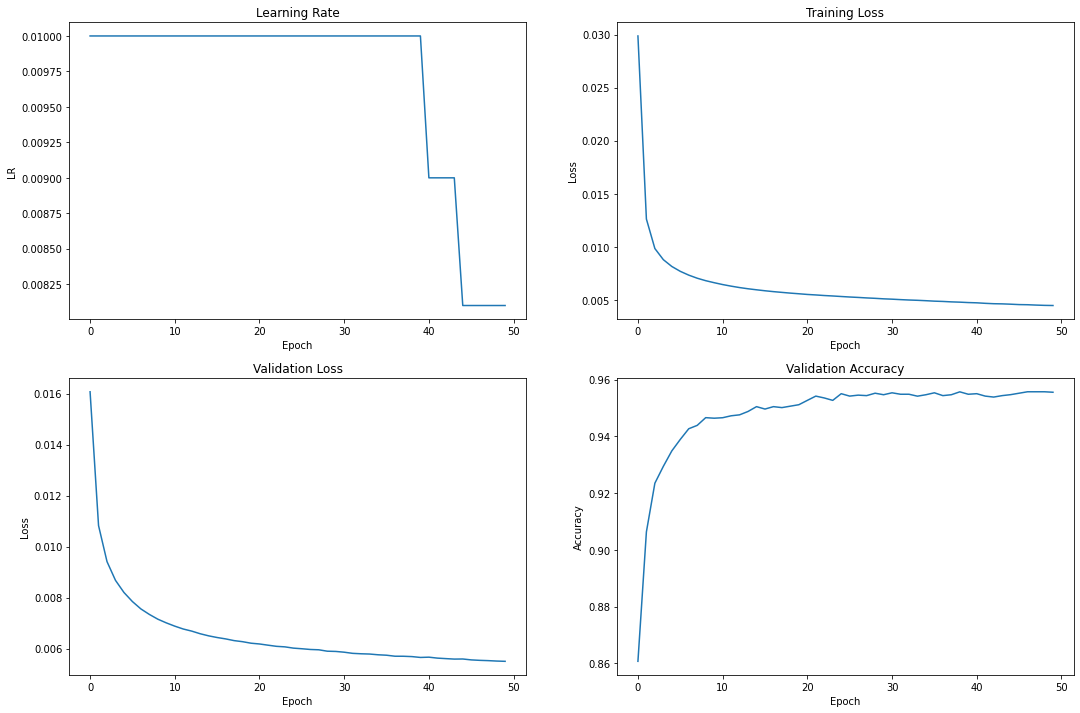

In [6]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


### 2.2. Hidden Units 128 & Weight Decay 0

In [7]:
model = create_model(hidden_units=128)
tuner = Tuner(model, 0, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model_128.npy"
tuner.train(max_epochs=50)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/50
	Learning Rate:  0.0100	Train Loss:  0.0056
	Val Loss:  0.0061	Val Accuracy:  0.9559
Epoch: 20/50
	Learning Rate:  0.0100	Train Loss:  0.0046
	Val Loss:  0.0053	Val Accuracy:  0.9604
Epoch: 30/50
	Learning Rate:  0.0090	Train Loss:  0.0040
	Val Loss:  0.0050	Val Accuracy:  0.9624
Epoch: 40/50
	Learning Rate:  0.0090	Train Loss:  0.0038
	Val Loss:  0.0048	Val Accuracy:  0.9632
Epoch: 50/50
	Learning Rate:  0.0066	Train Loss:  0.0035
	Val Loss:  0.0047	Val Accuracy:  0.9660
Training Finished. Best Epoch: 50/50
	Best Val Loss:  0.0047
	Best Val Accuracy:  0.9660
Test Accuracy:  0.9722


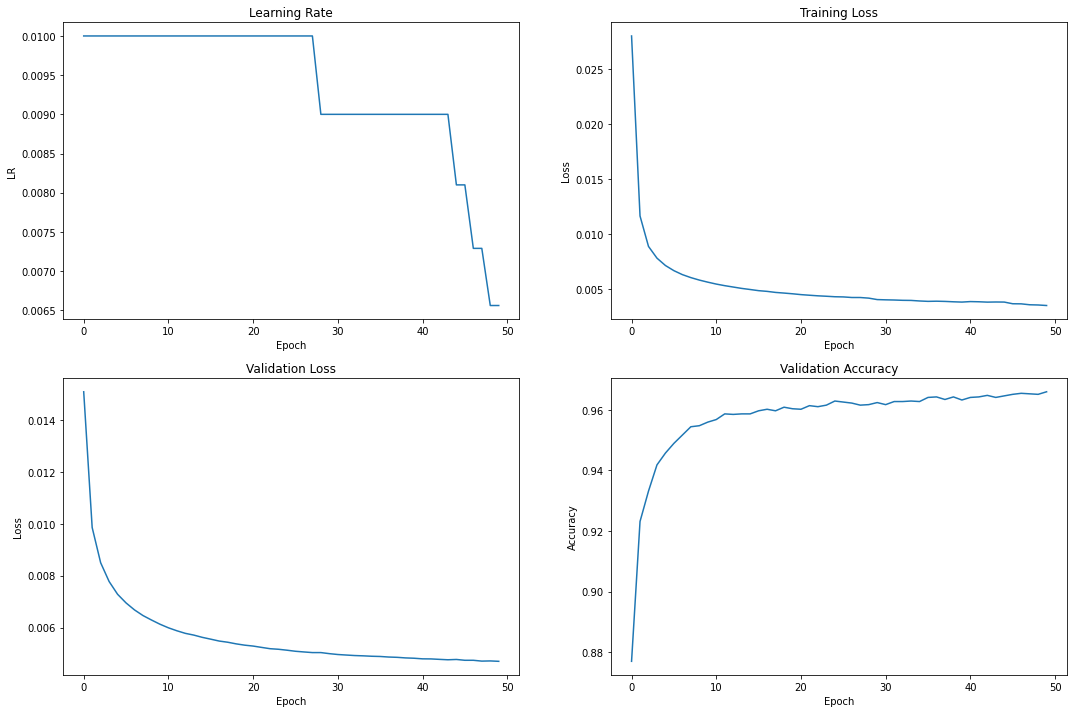

In [8]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


### 2.3. Hidden Units 256 & Weight Decay 0

In [9]:
model = create_model(hidden_units=256)
tuner = Tuner(model, 0, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model_256.npy"
tuner.train(max_epochs=50)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/50
	Learning Rate:  0.0100	Train Loss:  0.0050
	Val Loss:  0.0055	Val Accuracy:  0.9624
Epoch: 20/50
	Learning Rate:  0.0100	Train Loss:  0.0040
	Val Loss:  0.0047	Val Accuracy:  0.9675
Epoch: 30/50
	Learning Rate:  0.0090	Train Loss:  0.0035
	Val Loss:  0.0044	Val Accuracy:  0.9668
Epoch: 40/50
	Learning Rate:  0.0066	Train Loss:  0.0030
	Val Loss:  0.0043	Val Accuracy:  0.9678
Epoch: 50/50
	Learning Rate:  0.0048	Train Loss:  0.0028
	Val Loss:  0.0042	Val Accuracy:  0.9678
Training Finished. Best Epoch: 48/50
	Best Val Loss:  0.0042
	Best Val Accuracy:  0.9683
Test Accuracy:  0.9747


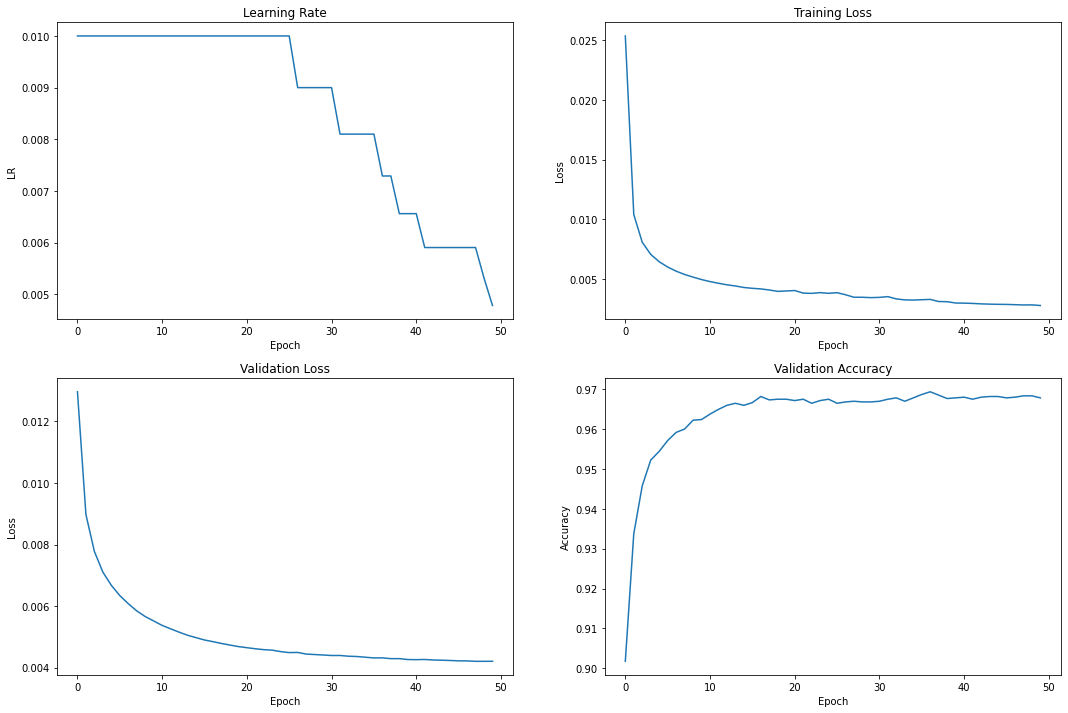

In [10]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


### 2.4. Hidden Units 512 & Weight Decay 0

In [11]:
model = create_model(hidden_units=512)
tuner = Tuner(model, 0, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model_512.npy"
tuner.train(max_epochs=50)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/50
	Learning Rate:  0.0100	Train Loss:  0.0045
	Val Loss:  0.0052	Val Accuracy:  0.9670
Epoch: 20/50
	Learning Rate:  0.0090	Train Loss:  0.0035
	Val Loss:  0.0046	Val Accuracy:  0.9690
Epoch: 30/50
	Learning Rate:  0.0090	Train Loss:  0.0031
	Val Loss:  0.0043	Val Accuracy:  0.9722
Epoch: 40/50
	Learning Rate:  0.0081	Train Loss:  0.0026
	Val Loss:  0.0042	Val Accuracy:  0.9724
Epoch: 50/50
	Learning Rate:  0.0073	Train Loss:  0.0025
	Val Loss:  0.0041	Val Accuracy:  0.9736
Training Finished. Best Epoch: 49/50
	Best Val Loss:  0.0041
	Best Val Accuracy:  0.9736
Test Accuracy:  0.9785


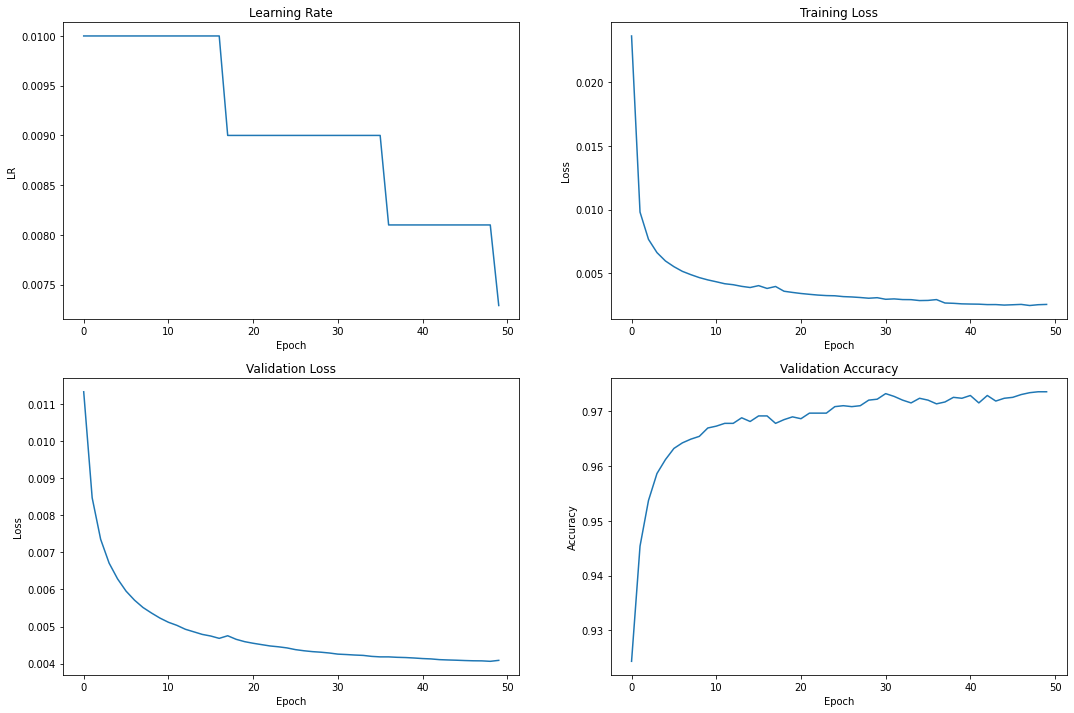

In [12]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


### 2.5. Hidden Units 64 & Weight Decay 1e-5

In [5]:
model = create_model(hidden_units=64)
tuner = Tuner(model, 1e-5, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model_64_e5.npy"
tuner.train(max_epochs=50)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/50
	Learning Rate:  0.0100	Train Loss:  0.0067
	Val Loss:  0.0068	Val Accuracy:  0.9500
Epoch: 20/50
	Learning Rate:  0.0100	Train Loss:  0.0057
	Val Loss:  0.0060	Val Accuracy:  0.9575
Epoch: 30/50
	Learning Rate:  0.0090	Train Loss:  0.0054
	Val Loss:  0.0056	Val Accuracy:  0.9597
Epoch: 40/50
	Learning Rate:  0.0090	Train Loss:  0.0050
	Val Loss:  0.0052	Val Accuracy:  0.9612
Epoch: 50/50
	Learning Rate:  0.0081	Train Loss:  0.0045
	Val Loss:  0.0050	Val Accuracy:  0.9624
Training Finished. Best Epoch: 50/50
	Best Val Loss:  0.0050
	Best Val Accuracy:  0.9624
Test Accuracy:  0.9644


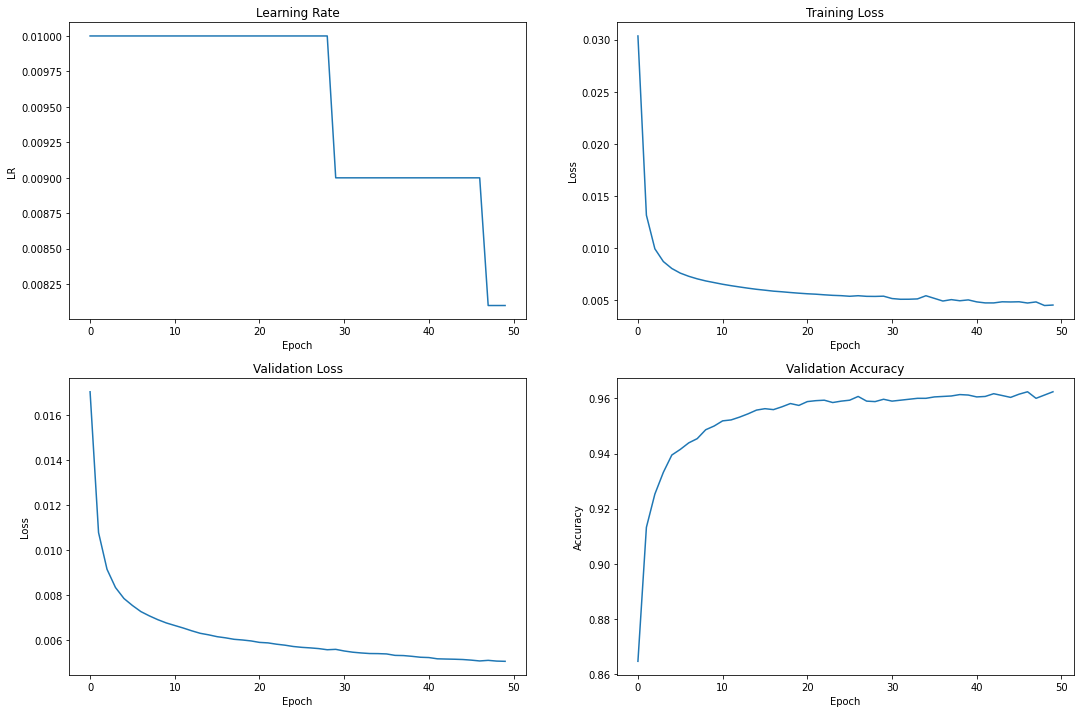

In [6]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


### 2.6. Hidden Units 128 & Weight Decay 1e-5

In [5]:
model = create_model(hidden_units=128)
tuner = Tuner(model, 1e-5, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model_128_e5.npy"
tuner.train(max_epochs=50)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/50
	Learning Rate:  0.0100	Train Loss:  0.0055
	Val Loss:  0.0059	Val Accuracy:  0.9564
Epoch: 20/50
	Learning Rate:  0.0100	Train Loss:  0.0044
	Val Loss:  0.0051	Val Accuracy:  0.9622
Epoch: 30/50
	Learning Rate:  0.0100	Train Loss:  0.0040
	Val Loss:  0.0047	Val Accuracy:  0.9660
Epoch: 40/50
	Learning Rate:  0.0073	Train Loss:  0.0036
	Val Loss:  0.0045	Val Accuracy:  0.9660
Epoch: 50/50
	Learning Rate:  0.0053	Train Loss:  0.0034
	Val Loss:  0.0044	Val Accuracy:  0.9672
Training Finished. Best Epoch: 49/50
	Best Val Loss:  0.0044
	Best Val Accuracy:  0.9668
Test Accuracy:  0.9723


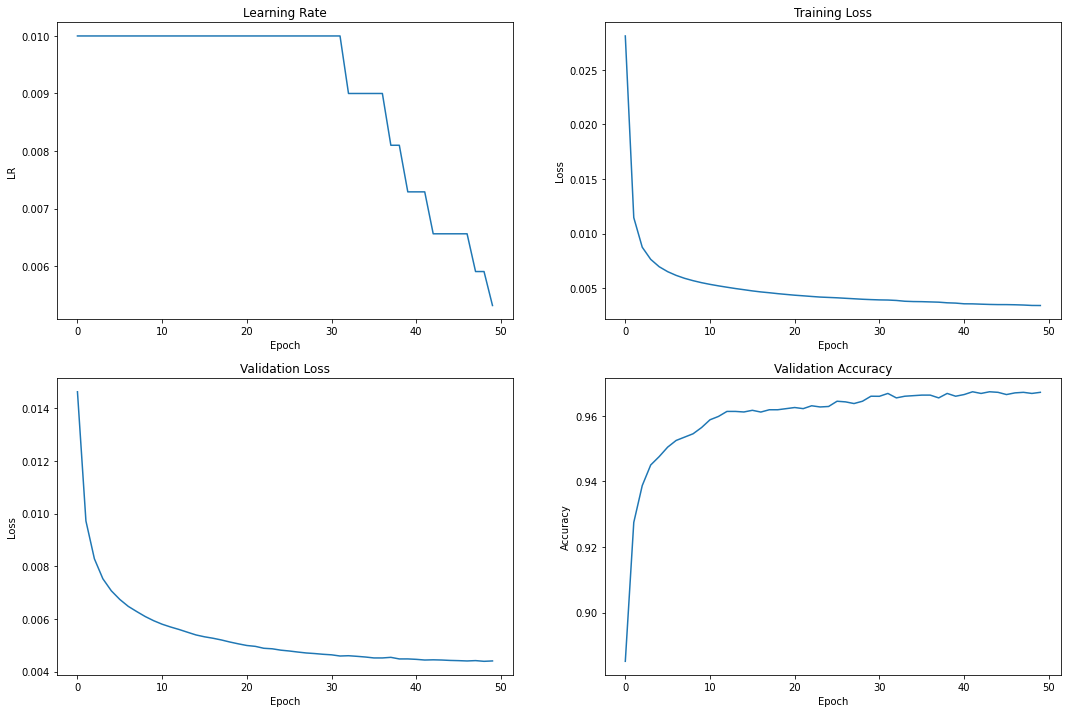

In [6]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


### 2.3. Hidden Units 256 & Weight Decay 1e-5

In [7]:
model = create_model(hidden_units=256)
tuner = Tuner(model, 1e-5, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model_256_e5.npy"
tuner.train(max_epochs=50)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/50
	Learning Rate:  0.0100	Train Loss:  0.0050
	Val Loss:  0.0054	Val Accuracy:  0.9614
Epoch: 20/50
	Learning Rate:  0.0100	Train Loss:  0.0039
	Val Loss:  0.0046	Val Accuracy:  0.9671
Epoch: 30/50
	Learning Rate:  0.0100	Train Loss:  0.0034
	Val Loss:  0.0042	Val Accuracy:  0.9721
Epoch: 40/50
	Learning Rate:  0.0081	Train Loss:  0.0030
	Val Loss:  0.0040	Val Accuracy:  0.9735
Epoch: 50/50
	Learning Rate:  0.0066	Train Loss:  0.0028
	Val Loss:  0.0039	Val Accuracy:  0.9743
Training Finished. Best Epoch: 50/50
	Best Val Loss:  0.0039
	Best Val Accuracy:  0.9743
Test Accuracy:  0.9761


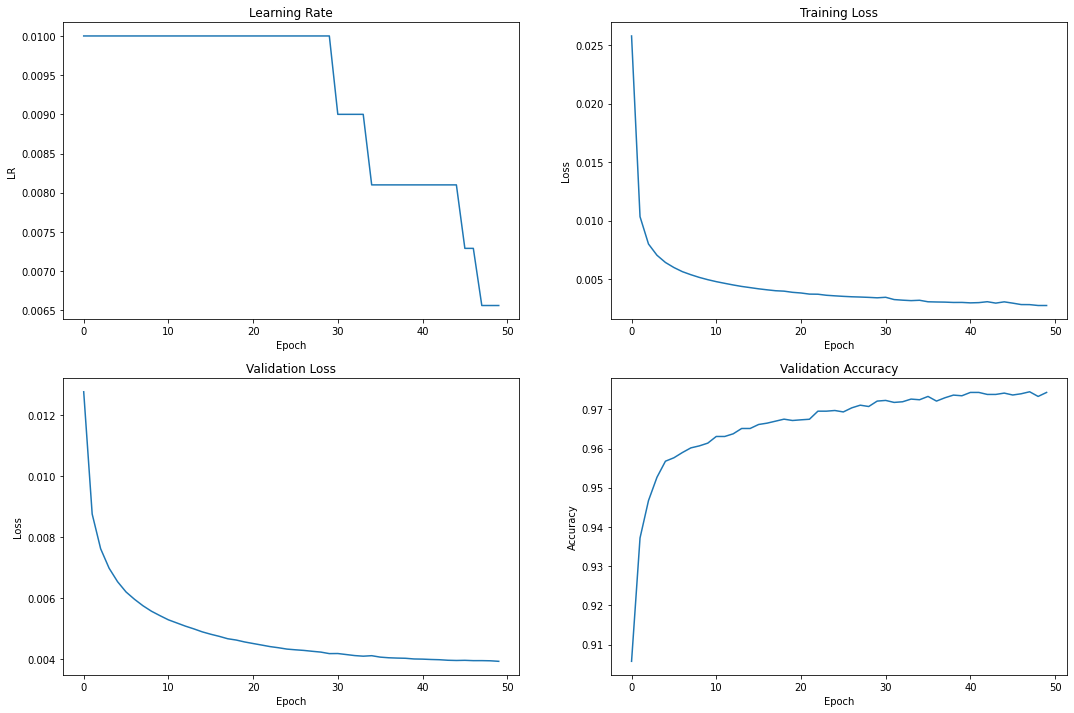

In [8]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


### 2.4. Hidden Units 512 & Weight Decay 1e-5

In [9]:
model = create_model(hidden_units=512)
tuner = Tuner(model, 1e-5, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model_512_e5.npy"
tuner.train(max_epochs=50)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/50
	Learning Rate:  0.0100	Train Loss:  0.0044
	Val Loss:  0.0051	Val Accuracy:  0.9688
Epoch: 20/50
	Learning Rate:  0.0100	Train Loss:  0.0035
	Val Loss:  0.0044	Val Accuracy:  0.9727
Epoch: 30/50
	Learning Rate:  0.0100	Train Loss:  0.0031
	Val Loss:  0.0041	Val Accuracy:  0.9722
Epoch: 40/50
	Learning Rate:  0.0081	Train Loss:  0.0027
	Val Loss:  0.0040	Val Accuracy:  0.9733
Epoch: 50/50
	Learning Rate:  0.0053	Train Loss:  0.0022
	Val Loss:  0.0039	Val Accuracy:  0.9736
Training Finished. Best Epoch: 49/50
	Best Val Loss:  0.0039
	Best Val Accuracy:  0.9738
Test Accuracy:  0.9792


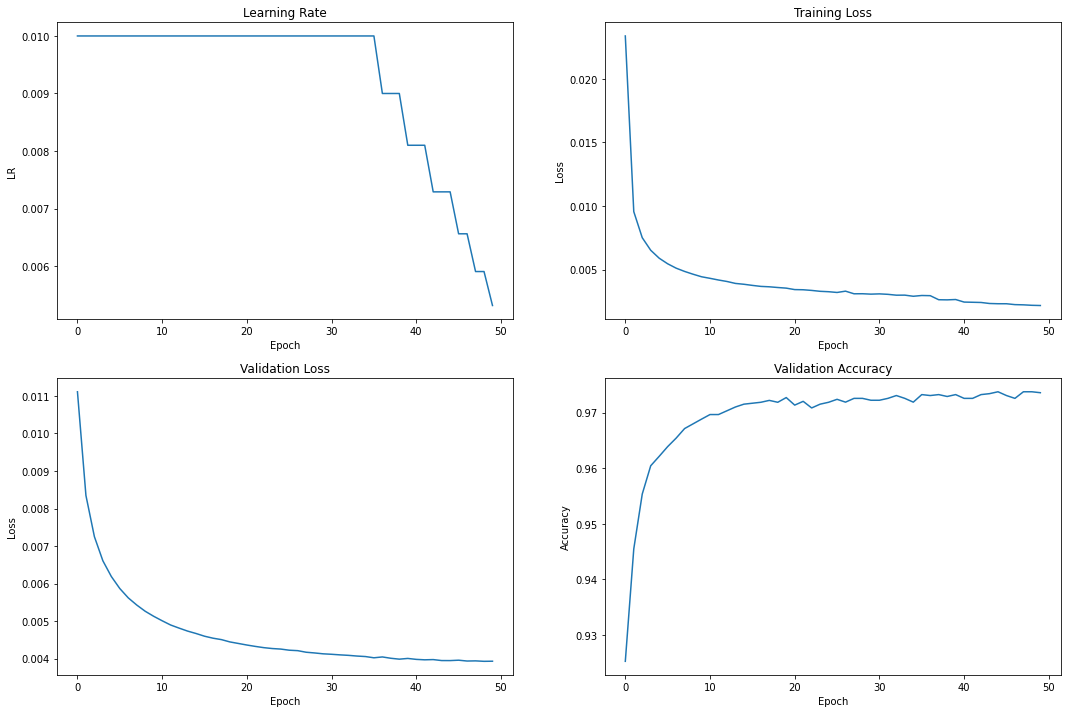

In [10]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


## 3. Dive into Best Model

In [14]:
model = create_model(hidden_units=512)
tuner = Tuner(model, 1e-5, train_loader, val_loader, test_loader)

save_path = "./best_models/best_model.npy"
tuner.train(max_epochs=80)
tuner.save_best(save_path)
tuner.test(save_path)


Epoch: 10/80
	Learning Rate:  0.0100	Train Loss:  0.0045
	Val Loss:  0.0051	Val Accuracy:  0.9687
Epoch: 20/80
	Learning Rate:  0.0100	Train Loss:  0.0035
	Val Loss:  0.0044	Val Accuracy:  0.9738
Epoch: 30/80
	Learning Rate:  0.0100	Train Loss:  0.0032
	Val Loss:  0.0041	Val Accuracy:  0.9762
Epoch: 40/80
	Learning Rate:  0.0100	Train Loss:  0.0029
	Val Loss:  0.0039	Val Accuracy:  0.9762
Epoch: 50/80
	Learning Rate:  0.0081	Train Loss:  0.0024
	Val Loss:  0.0039	Val Accuracy:  0.9763
Epoch: 60/80
	Learning Rate:  0.0059	Train Loss:  0.0021
	Val Loss:  0.0038	Val Accuracy:  0.9762
Epoch: 70/80
	Learning Rate:  0.0031	Train Loss:  0.0019
	Val Loss:  0.0038	Val Accuracy:  0.9762
Epoch: 80/80
	Learning Rate:  0.0017	Train Loss:  0.0018
	Val Loss:  0.0038	Val Accuracy:  0.9760
Training Finished. Best Epoch: 77/80
	Best Val Loss:  0.0038
	Best Val Accuracy:  0.9763
Test Accuracy:  0.9794


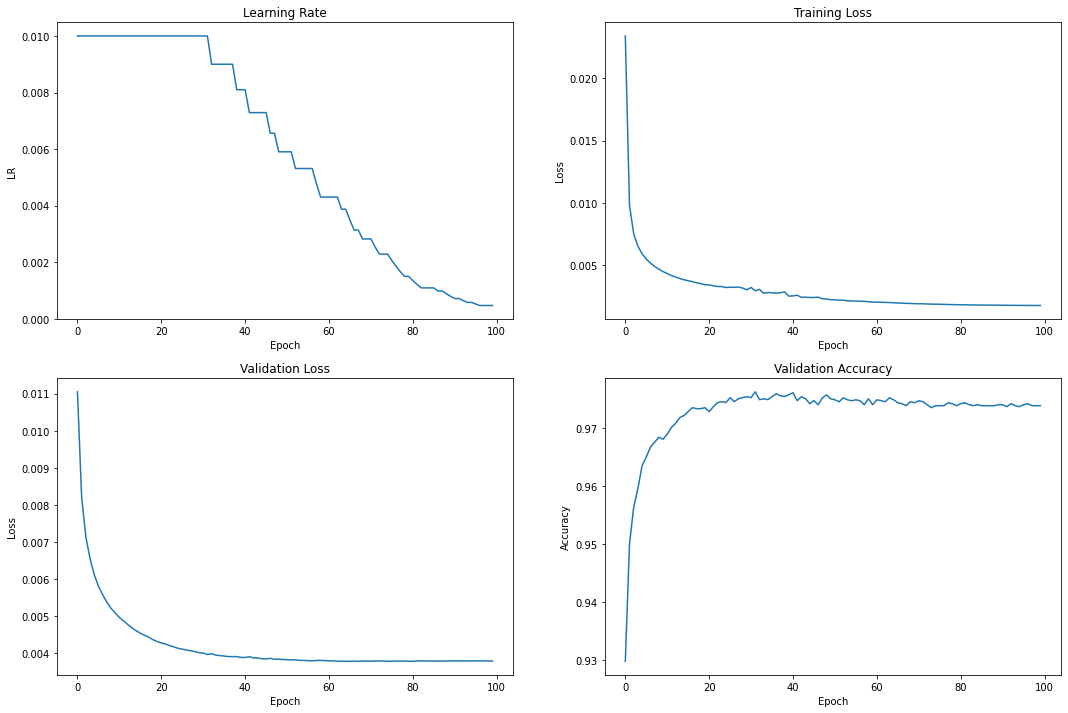

In [12]:
# Plot
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(tuner.lrs)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.subplot(2, 2, 2)
plt.plot(tuner.train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(tuner.val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(tuner.val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()
